# Plotting Notebook

This notebook generates all figures for the ICML 2026 paper. It contains plotting functions and visualizations for TARP experiments, GMM model shift analysis, InverseBench experiments, and more.

**Author:** Justine

**Data Directory:** `../data/`
**Output Directories:** `../plots/pdf/` and `../plots/png/`

In [1]:
"""
Consolidated imports, style configuration, and plotting utilities.
"""

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
from scipy.stats import chi2
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict, Any

CONFERENCE_NAME = "ICML 2026"  # Change as needed

# Set style and fonts
sns.set_theme(style="whitegrid", palette=None)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

if CONFERENCE_NAME == 'ICLR 2026' or CONFERENCE_NAME == 'ICML 2026':
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
elif CONFERENCE_NAME == 'NeurIPS 2026':
    print(f'Please check and come back to update the script for {CONFERENCE_NAME}.')
    # Throw an Error to remind user to update font settings
    raise ValueError(f"Font settings not configured for {CONFERENCE_NAME}")
elif CONFERENCE_NAME == 'AISTATS 2026':
    print(f'Please check and come back to update the script for {CONFERENCE_NAME}.')
    raise ValueError(f"Font settings not configured for {CONFERENCE_NAME}")
else:
    print(f'Please look up the conference font and update this script for {CONFERENCE_NAME}.')
    raise ValueError(f"Font settings not configured for {CONFERENCE_NAME}")


# =============================================================================
# Style Configuration
# =============================================================================

@dataclass
class PlotStyle:
    """Centralized style configuration for all plots."""
    fontsize: int = 20
    decrease_size: int = 2
    lw: float = 2.0
    alpha: float = 0.8
    fill_alpha: float = 0.2
    markersize: float = 18
    markeredgewidth: float = 5
    elinewidth: float = 3
    capsize: float = 15
    tick_color: str = 'black'
    
    @property
    def x_label_fontsize(self) -> int:
        return self.fontsize
    
    @property
    def y_label_fontsize(self) -> int:
        return self.fontsize
    
    @property
    def tick_fontsize(self) -> int:
        return self.fontsize - self.decrease_size
    
    @property
    def legend_fontsize(self) -> int:
        return self.fontsize - self.decrease_size - 3


# =============================================================================
# Color Utilities
# =============================================================================

def get_diverse_icefire_colors(n: int = 10) -> Tuple[List, List[str]]:
    """Generate n diverse colors from the icefire colormap."""
    cmap = sns.color_palette("icefire", as_cmap=True)
    positions = np.linspace(0, 1, n)
    colors = [cmap(pos) for pos in positions]
    return colors, [mcolors.to_hex(c) for c in colors]


def visualize_color_palette(colors_hex: List[str], title: str = "Selected Colors"):
    """Display a color palette for reference."""
    fig, ax = plt.subplots(figsize=(8, len(colors_hex) * 0.5))
    for i, hex_color in enumerate(colors_hex):
        ax.barh(i, 1, color=hex_color)
        ax.text(1.05, i, f'{i}: {hex_color}', va='center', fontsize=12)
    ax.set_xlim(0, 2)
    ax.set_ylim(-0.5, len(colors_hex) - 0.5)
    ax.axis('off')
    ax.set_title(title, fontsize=14, fontweight='bold')
    plt.show()


# Initialize colors
colors, colors_hex = get_diverse_icefire_colors(n=10)

# Reference colors for horizontal lines
POORLY_CALIBRATED_COLOR = colors_hex[0]
WELL_CALIBRATED_COLOR = colors_hex[9]

# Data colors (excluding light ends and dark bands)
data_colors_hex = [color for i, color in enumerate(colors_hex) if i not in [0, 3, 4, 5]]


## Color Definitions

Hex color palette definitions for consistent plot styling.

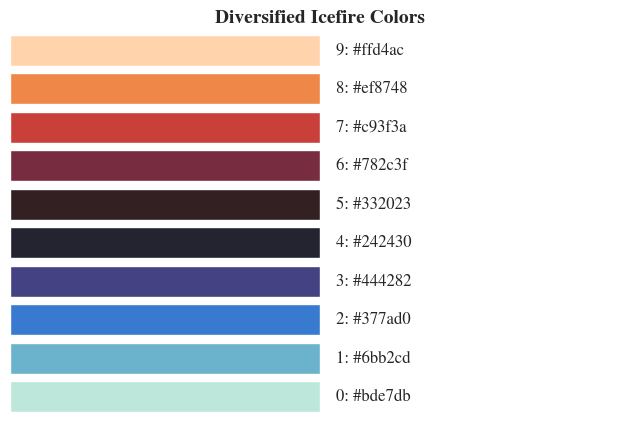

In [2]:
# Visualize the color palette
visualize_color_palette(colors_hex, title='Diversified Icefire Colors')

## Setup and Configuration

Path configuration and data loading verification.

In [3]:
PATH = '../data'

In [4]:
np.load(f'{PATH}/GMM_PQMass/shift_neg_6.npz')

NpzFile '../data/GMM_PQMass/shift_neg_6.npz' with keys: zs

## Plotting Functions

Core plotting functions used throughout the notebook.

In [5]:
# =============================================================================
# Data Loading Utilities
# =============================================================================

def load_tarp_results(filepath: str) -> Dict[str, np.ndarray]:
    """
    Load TARP results from npz file.
    Returns dict with 'alpha', 'mean', 'std' keys.
    Handles different key naming conventions in the data files.
    """
    data = np.load(filepath)
    
    # Handle different alpha key names
    if 'alpha' in data.files:
        alpha = data['alpha']
    elif 'alpha_bootstrap' in data.files:
        alpha = data['alpha_bootstrap']
    else:
        raise KeyError(f"No alpha key found in {filepath}")
    
    # Handle different ECP key names
    if 'ecp_mean' in data.files:
        mean = data['ecp_mean']
        std = data['ecp_std']
    elif 'ecp_bootstrap' in data.files:
        ecp = data['ecp_bootstrap']
        mean = ecp.mean(axis=0)
        std = ecp.std(axis=0)
    elif 'ecp_means' in data.files:
        mean = data['ecp_means']
        std = data['ecp_stds']
    else:
        raise KeyError(f"No ecp key found in {filepath}")
    
    return {'alpha': alpha, 'mean': mean, 'std': std}


# =============================================================================
# Core Plotting Functions
# =============================================================================

def plot_coverage_curve(
    ax,
    alpha: np.ndarray,
    mean: np.ndarray,
    std: np.ndarray,
    label: str,
    color: str,
    lw: float = 2.0,
    fill_alpha: float = 0.2,
    linestyle: str = '-',
    std_multiplier: float = 1.0,
    line_alpha: float = 1.0,
):
    """Plot a single coverage curve with uncertainty band."""
    ax.fill_between(
        alpha, 
        mean - std_multiplier * std, 
        mean + std_multiplier * std, 
        alpha=fill_alpha, 
        color=color
    )
    ax.plot(alpha, mean, linestyle, lw=lw, label=label, color=color, alpha=line_alpha)


def plot_coverage_curves(
    ax,
    curves: List[Dict[str, Any]],
    fontsize: int = 40,
    decrease_size: int = 2,
    lw: float = 2.0,
    xlabel: str = "Credibility Level",
    ylabel: str = "Expected Coverage",
    show_ideal: bool = True,
    xlim: Tuple[float, float] = (0, 1),
    ylim: Tuple[float, float] = (0, 1),
    show_legend: bool = False,
    legend_kwargs: dict = None,
):
    """
    Plot multiple coverage curves on a single axis.
    
    Parameters
    ----------
    ax : matplotlib.axes.Axes
    curves : list of dicts
        Each dict should have keys: 'alpha', 'mean', 'std', 'label', 'color'
        Optional keys: 'linestyle', 'std_multiplier', 'line_alpha'
    """
    tick_fontsize = fontsize - decrease_size
    tick_color = 'black'
    
    ax.grid(False)
    
    if show_ideal:
        ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    
    for curve in curves:
        plot_coverage_curve(
            ax,
            curve['alpha'],
            curve['mean'],
            curve['std'],
            curve['label'],
            curve['color'],
            lw=lw,
            linestyle=curve.get('linestyle', '-'),
            std_multiplier=curve.get('std_multiplier', 1.0),
            line_alpha=curve.get('line_alpha', 1.0),
        )
    
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=tick_fontsize, colors=tick_color)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    if show_legend:
        kwargs = {'fontsize': fontsize - decrease_size - 3}
        if legend_kwargs:
            kwargs.update(legend_kwargs)
        ax.legend(**kwargs)


def plot_mira_scores(
    ax,
    x: np.ndarray,
    y: np.ndarray,
    yerr: np.ndarray,
    colors_hex: List[str] = None,
    fontsize: int = 20,
    decrease_size: int = 2,
    xlabel: str = None,
    ylabel: str = 'Mira Score',
    title: str = None,
    show_reference_line: bool = True,
    reference_value: float = 0.5,
    xtick_labels: List[str] = None,
    xtick_rotation: float = 0,
    labels: List[str] = None,
    lw: float = 5,
    markersize: float = 2,
    markeredgewidth: float = 2,
    elinewidth: float = 2,
    alpha: float = 0.5,
    capsize: float = 10,
    draw_fill: bool = False,
    L: int = None,
    model_name: str = None,
    add_legend: bool = None,
    **kwargs,  # Accept additional kwargs for backward compatibility
):
    """
    Plot Mira scores with error bars.
    Unified function replacing plot_scores_with_error_bars and plot_mira_alone.
    """
    tick_fontsize = fontsize - decrease_size
    tick_color = 'black'
    
    if colors_hex is None:
        colors_hex = get_diverse_icefire_colors(10)[1]
    
    ax.grid(False)
    
    # Plot error bars
    for i in range(len(x)):
        label = labels[i] if labels and i < len(labels) else (model_name if model_name else None)
        ax.errorbar(
            x[i], y[i], yerr=yerr[i], fmt='o',
            capsize=capsize,
            color=colors_hex[i % len(colors_hex)],
            markersize=markersize,
            alpha=alpha if not draw_fill else 1.0,
            markeredgewidth=markeredgewidth,
            elinewidth=elinewidth,
            label=label if i == 0 or not model_name else None,
        )
        print(f'Index {i} | Mira: {y[i]} pm {yerr[i]}')
    
    # Optional fill between reference lines
    if draw_fill and L is not None:
        variance = (1/18) / L
        std_val = np.sqrt(variance)
        x_range = np.linspace(min(x) - 0.5, max(x) + 0.5, 100)
        ax.fill_between(x_range, 2/3 - std_val, 2/3 + std_val, alpha=0.2, color='black')
        ax.axhline(2/3, color='black', linestyle='--', alpha=1.0, lw=1.5)
    
    # Reference line for poorly calibrated
    if show_reference_line:
        ax.axhline(reference_value, color='gray', linestyle='--', alpha=1.0, lw=1.5)
    
    # Formatting
    if title:
        ax.set_title(title, fontsize=fontsize, fontweight='bold')
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=tick_fontsize, colors=tick_color)
    ax.tick_params(axis='y', labelsize=tick_fontsize, colors=tick_color)
    
    if xtick_labels is not None:
        ax.set_xticks(x)
        ax.set_xticklabels(xtick_labels, rotation=xtick_rotation)
    
    # Show legend if labels were provided
    if labels or model_name:
        ax.legend(fontsize=fontsize - decrease_size, loc='upper right')


def plot_histogram_comparison(
    ax,
    data_list: List[Tuple[np.ndarray, str, str]],
    fontsize: int = 40,
    decrease_size: int = 2,
    lw: float = 2.0,
    xlabel: str = None,
    ylabel: str = 'Frequency',
    bins: int = 20,
    show_chi2: bool = False,
    chi2_df: int = 99,
    chi2_range: Tuple[float, float] = (60, 160),
    legend_kwargs: dict = None,
):
    """
    Plot multiple histograms for comparison (e.g., PQMass results).
    
    Parameters
    ----------
    data_list : list of tuples
        Each tuple is (data_array, label, color)
    """
    tick_fontsize = fontsize - decrease_size
    tick_color = 'black'
    
    ax.grid(False)
    
    if show_chi2:
        x_chi2 = np.linspace(*chi2_range, 100)
        ax.plot(x_chi2, chi2.pdf(x_chi2, df=chi2_df), 
                lw=lw, label=r'$\chi^2_{\mathrm{ideal}}$', color='red')
    
    for data, label, color in data_list:
        ax.hist(data, bins=bins, density=True, label=label, 
                alpha=0.6, color=color, histtype='stepfilled', linewidth=lw)
    
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=tick_fontsize, colors=tick_color)
    
    if legend_kwargs:
        ax.legend(**legend_kwargs)


def plot_mira_training_curves(
    ax,
    cache,
    models: List[str],
    colors_hex: List[str],
    L: int = 100,
    ylabel: str = 'MIRA Score',
    xlabel: str = 'Epoch',
    title: str = None,
    lw: float = 1.5,
    fontsize: int = 20,
    markersize_trail: float = 3,
    markersize_final: float = 10,
    markeredgewidth: float = 1.5,
    alpha_trail: float = 0.3,
    alpha_final: float = 1.0,
    decrease_size: int = 2,
    well_calibrated_line: bool = True,
    poorly_calibrated_line: bool = True,
):
    """
    Plot MIRA score training curves with faded history and bold final points.
    """
    tick_fontsize = fontsize - decrease_size
    legend_fontsize = fontsize - decrease_size
    
    ax.grid(False)
    
    all_epochs = []
    variance = (1/18) / L
    std_val = np.sqrt(variance)

    # Reference lines
    if all_epochs:
        x_range = np.linspace(min(all_epochs) - 0.5, max(all_epochs) + 0.5, 100)
        if well_calibrated_line:
            ax.fill_between(x_range, 2/3 - std_val, 2/3 + std_val, alpha=0.2, color='black')
            ax.axhline(2/3, color='black', linestyle='--', lw=lw, alpha=1.0)
        if poorly_calibrated_line:
            ax.axhline(0.5, color='gray', linestyle='--', lw=lw, alpha=1.0)
    
    for model, color in zip(models, colors_hex):
        # Get model data from cache (handle different key formats)
        key_base = model.replace(' ', '_').replace('\n', '')
        epochs_key = f'{key_base}_epochs'
        scores_key = f'{key_base}_scores'
        
        # Try different key patterns
        if epochs_key not in cache.files:
            epochs_key = f'{model}_epochs'
            scores_key = f'{model}_scores'
        
        if epochs_key not in cache.files:
            print(f"Warning: Could not find data for {model}")
            continue
            
        epochs = cache[epochs_key]
        scores = cache[scores_key]
        all_epochs.extend(epochs)
        
        # Faded training history
        ax.plot(epochs, scores, marker='o', lw=lw, color=color,
                alpha=alpha_trail, markersize=markersize_trail, label=model)
        
        # Error band
        ax.fill_between(epochs, scores - std_val, scores + std_val,
                        color=color, alpha=0.15, linewidth=0)
        
        # Bold final point
        if len(epochs) > 0:
            ax.scatter(epochs[-1], scores[-1], s=markersize_final**2, color=color,
                       alpha=alpha_final, edgecolors='black',
                       linewidth=markeredgewidth/2, zorder=5)

    
    # Formatting
    if title:
        ax.set_title(title, fontsize=fontsize, fontweight='bold')
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.legend(fontsize=legend_fontsize, loc='lower right')


# Backward compatibility aliases
plot_mira_alone = plot_mira_scores
plot_scores_with_error_bars = plot_mira_scores


In [6]:
# =============================================================================
# Experiment-Specific Plot Functions  
# =============================================================================

def plot_validation_result(
    ax,
    experiment_type: str,
    data_colors_hex: List[str],
    fontsize: int = 40,
    decrease_size: int = 2,
    lw: float = 2.0,
    alpha: float = 0.8,
):
    """
    Unified function to plot validation results for different experiments.
    
    Parameters
    ----------
    experiment_type : str
        One of: 'pqmass', 'linear_regression', 'tarp_figure_2', 
        'model_misspecification', 'prior_noise_misspecification',
        'conditional_distribution', 'inversebench_black_hole',
        'inversebench_mri', 'inversebench_scattering'
    """
    
    if experiment_type == 'pqmass':
        _plot_pqmass(ax, data_colors_hex, fontsize, decrease_size, lw)
    elif experiment_type == 'linear_regression':
        _plot_linear_regression(ax, data_colors_hex, fontsize, decrease_size, lw)
    elif experiment_type == 'tarp_figure_2':
        _plot_tarp_figure_2(ax, data_colors_hex, fontsize, decrease_size, lw)
    elif experiment_type == 'model_misspecification':
        _plot_model_misspecification(ax, data_colors_hex, fontsize, decrease_size, lw)
    elif experiment_type == 'prior_noise_misspecification':
        _plot_prior_noise_misspecification(ax, data_colors_hex, fontsize, decrease_size, lw, alpha)
    elif experiment_type == 'conditional_distribution':
        _plot_conditional_distribution(ax, data_colors_hex, fontsize, decrease_size, lw)
    elif experiment_type == 'inversebench_black_hole':
        _plot_inversebench(ax, 'black_hole_imaging', ['DAPS', 'DiffPIR', 'DPS', 'PnPDM', 'REDDiff'],
                          data_colors_hex, fontsize, decrease_size, lw)
    elif experiment_type == 'inversebench_mri':
        _plot_inversebench(ax, 'compressed_sensing_mri', ['DAPS', 'DiffPIR', 'DPS', 'PnPDM', 'REDDiff'],
                          data_colors_hex, fontsize, decrease_size, lw)
    elif experiment_type == 'inversebench_scattering':
        _plot_inversebench(ax, 'linear_inverse_scattering', 
                          ['DAPS', 'DDRM', 'DDNM', 'PiGDM', 'DiffPIR', 'DPS', 'PnPDM', 'REDDiff'],
                          data_colors_hex, fontsize, decrease_size, lw)
    else:
        raise ValueError(f"Unknown experiment type: {experiment_type}")


def _plot_pqmass(ax, colors, fontsize, decrease_size, lw):
    """Plot PQMass chi-squared distribution comparison."""
    shifts = [('neg_6', -6), ('neg_3', -3), ('zero', 0), ('pos_3', 3), ('pos_6', 6)]
    
    data_list = []
    for i, (name, shift) in enumerate(shifts):
        pqmass = np.load(f'{PATH}/GMM_PQMass/shift_{name}.npz')
        zs_combined = np.concatenate(pqmass['zs'])
        data_list.append((zs_combined, f'Shift: {shift}', colors[i]))
    
    plot_histogram_comparison(
        ax, data_list, fontsize=fontsize, decrease_size=decrease_size, lw=lw,
        xlabel=r'$\chi^2_{{\rm PQM}}$', show_chi2=True, chi2_df=99,
        legend_kwargs={'loc': 'upper right', 'ncol': 3, 'fontsize': fontsize - decrease_size - 3}
    )


def _plot_linear_regression(ax, colors, fontsize, decrease_size, lw):
    """Plot linear regression TARP bootstrap results."""
    lr_data = np.load(f'{PATH}/LR_TARP_Bootstrap_Data/LR_TARP_Bootstrap_Data.npz')
    alpha = lr_data['alpha']
    noise_levels = lr_data['noise_levels']
    ecp_means = lr_data['ecp_means']
    ecp_stds = lr_data['ecp_stds']
    
    curves = []
    for i in range(len(noise_levels)):
        curves.append({
            'alpha': alpha,
            'mean': ecp_means[i],
            'std': ecp_stds[i],
            'label': f"Noise: {noise_levels[i]:.3f}",
            'color': colors[i % len(colors)],
        })
    
    plot_coverage_curves(ax, curves, fontsize=fontsize, decrease_size=decrease_size, lw=lw)


def _plot_tarp_figure_2(ax, colors, fontsize, decrease_size, lw):
    """Plot TARP Figure 2: four posterior cases."""
    cases = [
        ('correct', '$p(x)$', '-'),
        ('overconfident', '$q(x)$', '.-'),
        ('underconfident', '$r(x)$', '-'),
        ('biased', '$s(x)$', '--'),
    ]
    
    curves = []
    for i, (case_name, label, ls) in enumerate(cases):
        data = np.load(f'{PATH}/Tarp_Fig_2_Results/tarp_coverage_{case_name}_tarp_results.npz')
        alpha = data['alpha_bootstrap']
        ecp = data['ecp_bootstrap']
        curves.append({
            'alpha': alpha,
            'mean': ecp.mean(axis=0),
            'std': ecp.std(axis=0),
            'label': label,
            'color': colors[i],
            'linestyle': ls,
        })
    
    plot_coverage_curves(ax, curves, fontsize=fontsize, decrease_size=decrease_size, lw=lw)


def _plot_model_misspecification(ax, colors, fontsize, decrease_size, lw):
    """Plot model misspecification results."""
    data = np.load(f'{PATH}/model_misspecification_tarp_data.npz')
    
    configs = [
        ('EPL + 3 sources', 'EPL + 3 Sources'),
        ('EPL + 1 sources', 'EPL + 1 Source'),
        ('SIE + 3 sources', 'SIE + 3 Sources'),
        ('SIE + 1 sources', 'SIE + 1 Source'),
    ]
    
    curves = []
    for i, (key_prefix, label) in enumerate(configs):
        curves.append({
            'alpha': data[f'{key_prefix}_alpha'],
            'mean': data[f'{key_prefix}_ecp_mean'],
            'std': data[f'{key_prefix}_ecp_std'],
            'label': label,
            'color': colors[i],
        })
    
    plot_coverage_curves(ax, curves, fontsize=fontsize, decrease_size=decrease_size, lw=lw)


def _plot_prior_noise_misspecification(ax, colors, fontsize, decrease_size, lw, line_alpha):
    """Plot prior and noise misspecification (lensing) results."""
    data = np.load(f'{PATH}/lens_exp/Lensing_tarp_coverage_data.npz')
    
    configs = [
        (1, '$p_s(x)$, $\\sigma_{\\eta}=2$', '-'),
        (2, '$p_s(x)$, $\\sigma_{\\eta}=4$', '.-'),
        (3, '$p_m(x)$, $\\sigma_{\\eta}=2$', '-'),
        (4, '$p_m(x)$, $\\sigma_{\\eta}=4$', '--'),
    ]
    
    curves = []
    for i, (num, label, ls) in enumerate(configs):
        curves.append({
            'alpha': data[f'posterior_{num}_alpha'],
            'mean': data[f'posterior_{num}_ecp_mean'],
            'std': data[f'posterior_{num}_ecp_std'],
            'label': label,
            'color': colors[i],
            'linestyle': ls,
            'line_alpha': 0.5,
        })
    
    plot_coverage_curves(ax, curves, fontsize=fontsize, decrease_size=decrease_size, lw=lw)


def _plot_conditional_distribution(ax, colors, fontsize, decrease_size, lw):
    """Plot conditional distribution model results."""
    data = np.load(f'{PATH}/TARP_Plots_Conditional_Model/Tarp_Result_Averaged_Data.npz')
    
    common_alpha = np.linspace(0, 1, 101)
    common_alpha_ext = np.insert(common_alpha, 0, 0.0)
    
    cdm_mean = data['cdm_mean_ecp'].copy()
    cdm_std = data['cdm_std_ecp'].copy()
    # Apply correction from original code
    cdm_mean[1] = 0.00547937
    cdm_std[1] = 8.69164966e-05
    
    curves = [
        {'alpha': common_alpha_ext, 'mean': cdm_mean, 'std': cdm_std,
         'label': 'CDM', 'color': colors[0], 'std_multiplier': 3.0},
        {'alpha': common_alpha_ext, 'mean': data['cvae_mean_ecp'], 'std': data['cvae_std_ecp'],
         'label': 'CVAE', 'color': colors[1], 'std_multiplier': 3.0},
    ]
    
    plot_coverage_curves(ax, curves, fontsize=fontsize, decrease_size=decrease_size, lw=lw,
                        show_legend=True, legend_kwargs={'fontsize': 16, 'loc': 'upper left'})


def _plot_inversebench(ax, experiment, methods, colors, fontsize, decrease_size, lw):
    """Plot InverseBench TARP results."""
    base_path = f'{PATH}/InverseBench/{experiment}'
    
    curves = []
    for i, method in enumerate(methods):
        try:
            data = load_tarp_results(f'{base_path}/{method}_tarp_results.npz')
            # Handle special label for piGDM
            label = r'$\pi\text{GDM}$' if method == 'PiGDM' else method
            curves.append({
                'alpha': data['alpha'],
                'mean': data['mean'],
                'std': data['std'],
                'label': label,
                'color': colors[i % len(colors)],
            })
        except (FileNotFoundError, KeyError) as e:
            print(f"Warning: Could not load {method} data: {e}")
    
    plot_coverage_curves(ax, curves, fontsize=fontsize, decrease_size=decrease_size, lw=lw,
                        ylim=(-0.05, 1))


## TARP Figure 2 Plots

Figure 2: TARP coverage analysis showing biased, overconfident, underconfident, and correct posteriors.

In [7]:
FONTSIZE = 17
LW = 1.5
ALPHA = 0.9
MARKERDGEWIDTH = 1.5
MARKERSIZE = 8
ELINEWIDTH = 2
CAPSIZE = 10
DECREASE_SIZE = 4

Index 0 | Mira: 0.6624516844749451 pm 0.00697891553863883
Index 1 | Mira: 0.618563711643219 pm 0.00876374077051878
Index 2 | Mira: 0.6938722133636475 pm 0.007383645512163639
Index 3 | Mira: 0.5444898009300232 pm 0.007584034465253353


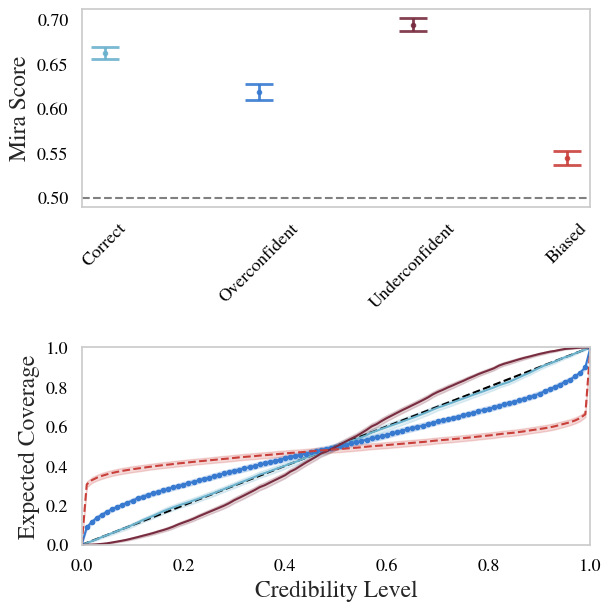

In [8]:
# TARP Figure 2 Mira + Tarp plots

cases = ['Correct', 'Overconfident', 'Underconfident', 'Biased']
scores = [0.6624516844749451, 0.618563711643219, 0.6938722133636475, 0.5444898009300232]
errors = [0.00697891553863883, 0.00876374077051878, 0.007383645512163639, 0.007584034465253353]

L = 1000 # number of fiducials -> to be updt if needed

fig1, axes1 = plt.subplots(nrows=2,
    ncols=1,
    figsize=(6, 6),
    gridspec_kw={'hspace': 0.1}  # Try values between 0.2 and 0.5
)
left_ax1, right_ax1 = axes1

plot_mira_scores(
    x=np.arange(len(cases)),
    y=scores,
    L = L,
    ax=left_ax1,
    colors_hex=data_colors_hex,
    yerr=errors,
    xtick_labels=cases,
    xtick_rotation=45,
    # xlabel='Posteriors',
    ylabel='Mira Score',
    table_number='Table_1',
    LR=False,
    well_calibrated_color=WELL_CALIBRATED_COLOR,
    poorly_calibrated_color=POORLY_CALIBRATED_COLOR,
    lw=LW,
    fontsize=FONTSIZE,
    alpha=ALPHA,
    decrease_size=DECREASE_SIZE
)
plot_validation_result(
    ax=right_ax1, 
    experiment_type='tarp_figure_2', 
    data_colors_hex=data_colors_hex,
    lw=LW,
    fontsize=FONTSIZE,
    alpha=ALPHA,
    decrease_size=DECREASE_SIZE
)

fig1.set_constrained_layout(True)
fig1.savefig('../plots/pdf/Tarp_Fig2_Pokie_Tarp.pdf')
fig1.savefig('../plots/png/Tarp_Fig2_Pokie_Tarp.png', dpi=300)

## GMM Model Shift Analysis

Distribution shift experiments with Gaussian Mixture Models.

Index 0 | Mira: 0.5006 pm 0.0137
Index 1 | Mira: 0.5004 pm 0.0141
Index 2 | Mira: 0.6667 pm 0.0102
Index 3 | Mira: 0.5017 pm 0.012
Index 4 | Mira: 0.5013 pm 0.0134


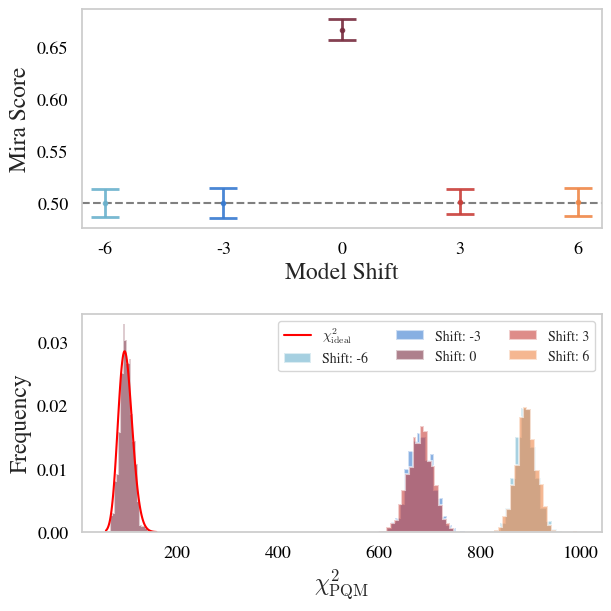

In [9]:
model_shifts = [-6, -3, 0, 3, 6]
scores = [0.5006, 0.5004, 0.6667, 0.5017, 0.5013]
errors = [0.0137, 0.0141, 0.0102, 0.0120, 0.0134]
L = 500 # number of fiducials -> to be updt if needed

fig2, axes2 = plt.subplots(nrows=2,
    ncols=1,
    figsize=(6, 6),
    gridspec_kw={'hspace': 0.1}  # Try values between 0.2 and 0.5
)
left_ax2, right_ax2 = axes2

plot_mira_scores(
    x=model_shifts,
    y=scores,
    L=L,
    ax=left_ax2,
    yerr=errors,
    xtick_labels=model_shifts,
    xlabel='Model Shift',
    ylabel='Mira Score',
    table_number='Table_GMM',
    bbox_x=1.02,
    bbox_y=0.90,
    # title='Distribution Shift',
    colors_hex=data_colors_hex,
    well_calibrated_color=WELL_CALIBRATED_COLOR,
    poorly_calibrated_color=POORLY_CALIBRATED_COLOR,
    lw=LW,
    fontsize=FONTSIZE,
    alpha=ALPHA,
    decrease_size=DECREASE_SIZE
)
# fig2.suptitle('Distribution Shift', fontsize=60, fontweight='bold', y=1.00)  # adjust `y` as needed
plot_validation_result(
    ax=right_ax2,
    experiment_type='pqmass',
    data_colors_hex=data_colors_hex,
    lw=LW,
    fontsize=FONTSIZE,
    alpha=ALPHA,
    decrease_size=DECREASE_SIZE
    )

fig2.set_constrained_layout(True)
fig2.savefig('../plots/pdf/Distribution_Shift_Result.pdf')
fig2.savefig('../plots/png/Distribution_Shift_Result.png', dpi=300)

## Lensing Experiments

Gravitational lensing posterior analysis.

Index 0 | Mira: 0.6319946646690369 pm 0.025168711319565773
Index 1 | Mira: 0.5787630081176758 pm 0.02674553170800209
Index 2 | Mira: 0.5393556356430054 pm 0.02755758911371231
Index 3 | Mira: 0.5222544074058533 pm 0.028337465599179268


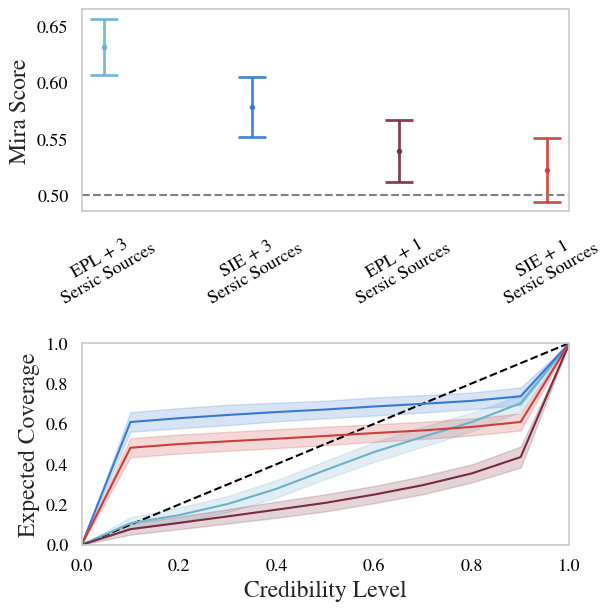

In [10]:
models = [
    "EPL + 3\nSersic Sources",
    "SIE + 3\nSersic Sources",
    "EPL + 1\nSersic Sources",
    "SIE + 1\nSersic Sources"
]
scores = [0.6319946646690369, 0.5787630081176758, 0.5393556356430054, 0.5222544074058533]
errors = [0.025168711319565773, 0.02674553170800209, 0.02755758911371231, 0.028337465599179268]
L = 100

FONTSIZE = 17
LW = 1.5
ALPHA = 0.9
MARKERDGEWIDTH = 1.5
MARKERSIZE = 8
ELINEWIDTH = 2
CAPSIZE = 10
DECREASE_SIZE = 4


fig4, axes4 = plt.subplots(nrows=2,
    ncols=1,
    figsize=(6, 6),
    gridspec_kw={'hspace': 0.1}  # Try values between 0.2 and 0.5
)
left_ax4, right_ax4 = axes4

plot_mira_scores(
    x=range(len(models)),  # Use index for x-axis
    y=scores,
    L=L,
    yerr=errors,
    ax=left_ax4,
    ylabel='Mira Score',
    xtick_labels=models,
    xtick_rotation=30,
    table_number='Model_Misspecification',
    colors_hex=data_colors_hex,
    well_calibrated_color=WELL_CALIBRATED_COLOR,
    poorly_calibrated_color=POORLY_CALIBRATED_COLOR,
    lw=LW,
    fontsize=FONTSIZE,
    alpha=ALPHA,
    decrease_size=DECREASE_SIZE
    # title='Model Misspecification',
)
# fig4.suptitle('Model Misspecification', fontsize=60, fontweight='bold', y=1.00)  # adjust `y` as needed
plot_validation_result(ax=right_ax4, experiment_type='model_misspecification', data_colors_hex=data_colors_hex, lw=LW,
    fontsize=FONTSIZE,
    alpha=ALPHA,decrease_size=DECREASE_SIZE )

fig4.set_constrained_layout(True)
fig4.savefig('../plots/pdf/Model_Misspecification_Result.pdf')
fig4.savefig('../plots/png/Model_Misspecification_Result.png', dpi=300)

## InverseBench Experiments

Inverse problems benchmark experiments.

Index 0 | Mira: 0.6442 pm 0.0606
Index 1 | Mira: 0.5783 pm 0.0728
Index 2 | Mira: 0.5298 pm 0.0748
Index 3 | Mira: 0.5056 pm 0.069


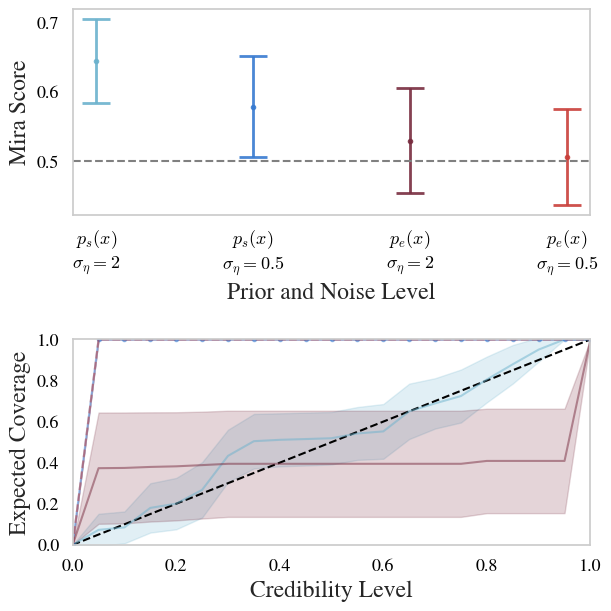

In [11]:
conditions = [
    r"$p_s(x)$" + "\n" + r"$\sigma_{\eta}=2$",
    r"$p_s(x)$" + "\n" + r"$\sigma_{\eta}=0.5$",
    r"$p_e(x)$" + "\n" + r"$\sigma_{\eta}=2$",
    r"$p_e(x)$" + "\n" + r"$\sigma_{\eta}=0.5$"
]
scores = [0.6442, 0.5783, 0.5298, 0.5056]
errors = [0.0606, 0.0728, 0.0748, 0.0690]
L = 16


fig5, axes5 = plt.subplots(nrows=2,
    ncols=1,
    figsize=(6, 6),
    gridspec_kw={'hspace': 0.1}  # Try values between 0.2 and 0.5
)
left_ax5, right_ax5 = axes5

plot_mira_scores(
    x=range(len(conditions)),  # Use index for x-axis
    y=scores,
    L=L,
    yerr=errors,
    ax=left_ax5,
    xlabel='Prior and Noise Level',
    ylabel='Mira Score',
    xtick_labels=conditions,
    xtick_rotation=0,
    table_number='Table_Lensed_Images',
    bbox_x = 1.02,
    bbox_y = 0.87,
    colors_hex=data_colors_hex,
    well_calibrated_color=WELL_CALIBRATED_COLOR,
    poorly_calibrated_color=POORLY_CALIBRATED_COLOR,
    # title='Prior & Noise Misspecification',
    lw=LW,
    fontsize=FONTSIZE,
    alpha=ALPHA,
    decrease_size=DECREASE_SIZE
)
# fig5.suptitle('Prior & Noise Misspecification', fontsize=60, fontweight='bold', y=1.00)  # adjust `y` as needed
plot_validation_result(ax=right_ax5, experiment_type='prior_noise_misspecification', data_colors_hex=data_colors_hex,lw=LW,
    fontsize=FONTSIZE,
    alpha=ALPHA,decrease_size=DECREASE_SIZE )

fig5.set_constrained_layout(True)
fig5.savefig('../plots/pdf/Prior_and_Noise_Misspecification_Result.pdf')
fig5.savefig('../plots/png/Prior_and_Noise_Misspecification_Result.png', dpi=300)

Index 0 | Mira: 0.51140004 pm 0.0294348
Index 1 | Mira: 0.5089394 pm 0.02929415
Index 2 | Mira: 0.51294947 pm 0.03200674
Index 3 | Mira: 0.5096262 pm 0.02528337
Index 4 | Mira: 0.50591314 pm 0.02917956


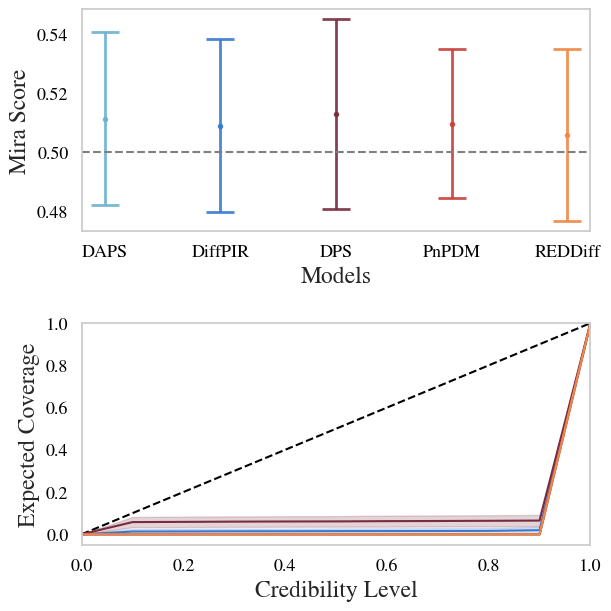

In [12]:
# InverseBench: Black Hole Imaging

models = [
    "DAPS",
    "DiffPIR",
    "DPS",
    "PnPDM",
    "REDDiff"
]

scores = [0.51140004, 0.5089394, 0.51294947, 0.5096262  , 0.50591314 ]
errors = [0.0294348, 0.02929415, 0.03200674, 0.02528337, 0.02917956]
L=100

fig6, axes6 = plt.subplots(nrows=2,
    ncols=1,
    figsize=(6, 6),
    gridspec_kw={'hspace': 0.1}  # Try values between 0.2 and 0.5
)
left_ax6, right_ax6 = axes6

plot_mira_scores(
    x=range(len(models)),  # Use index for x-axis
    y=scores,
    yerr=errors,
    L=L,
    ax=left_ax6,
    xlabel='Models',
    ylabel='Mira Score',
    xtick_labels=models,
    xtick_rotation=0,
    table_number='Table_IB_Black_Hole_Imaging',
    bbox_x = 1.02,
    bbox_y = 0.87,
    colors_hex=data_colors_hex,
    well_calibrated_color=WELL_CALIBRATED_COLOR,
    poorly_calibrated_color=POORLY_CALIBRATED_COLOR,
    lw=LW,
    fontsize=FONTSIZE,
    alpha=ALPHA,
    decrease_size=DECREASE_SIZE
    # title='Prior & Noise Misspecification',
)
# fig6.suptitle('Prior & Noise Misspecification', fontsize=60, fontweight='bold', y=1.00)  # adjust `y` as needed
plot_validation_result(ax=right_ax6, experiment_type='inversebench_black_hole', data_colors_hex=data_colors_hex,lw=LW,
    fontsize=FONTSIZE,
    alpha=ALPHA,decrease_size=DECREASE_SIZE )

fig6.set_constrained_layout(True)
fig6.savefig('../plots/pdf/InverseBench_BlackHoleImaging.pdf')
fig6.savefig('../plots/png/InverseBench_BlackHoleImaging.png', dpi=300)

Index 0 | Mira: 0.51496667 pm 0.10805649
Index 1 | Mira: 0.5051 pm 0.11640274
Index 2 | Mira: 0.57823336 pm 0.11745473
Index 3 | Mira: 0.5209 pm 0.10246222
Index 4 | Mira: 0.51143336 pm 0.11376356


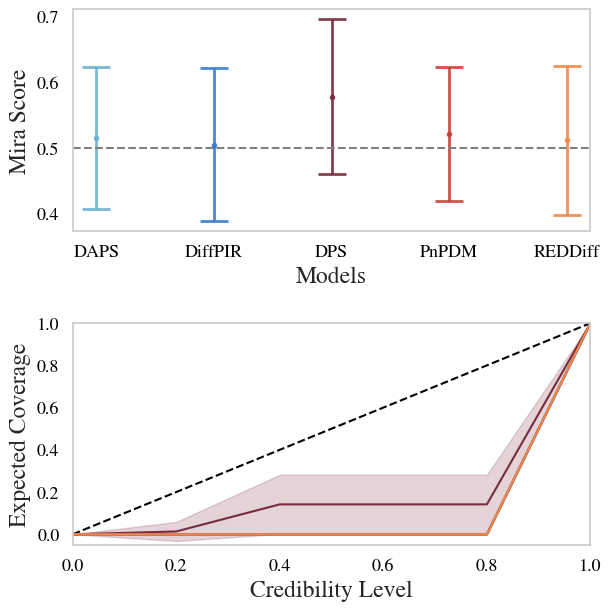

In [13]:
# InverseBench: Compressed Sensing MRI

models = [
    "DAPS",
    "DiffPIR",
    "DPS",
    "PnPDM",
    "REDDiff"
]
scores = [0.51496667, 0.5051, 0.57823336, 0.5209, 0.51143336]
errors = [0.10805649, 0.11640274, 0.11745473, 0.10246222, 0.11376356]

L=6

fig6, axes6 = plt.subplots(nrows=2,
    ncols=1,
    figsize=(6, 6),
    gridspec_kw={'hspace': 0.1}  # Try values between 0.2 and 0.5
)
left_ax6, right_ax6 = axes6

plot_mira_scores(
    x=range(len(models)),  # Use index for x-axis
    y=scores,
    yerr=errors,
    L=L,
    ax=left_ax6,
    xlabel='Models',
    ylabel='Mira Score',
    xtick_labels=models,
    xtick_rotation=0,
    table_number='Table_IB_Black_Hole_Imaging',
    bbox_x = 1.02,
    bbox_y = 0.87,
    colors_hex=data_colors_hex,
    well_calibrated_color=WELL_CALIBRATED_COLOR,
    poorly_calibrated_color=POORLY_CALIBRATED_COLOR,
    lw=LW,
    fontsize=FONTSIZE,
    alpha=ALPHA,
    decrease_size=DECREASE_SIZE
    # title='Prior & Noise Misspecification',
)
# fig6.suptitle('Prior & Noise Misspecification', fontsize=60, fontweight='bold', y=1.00)  # adjust `y` as needed
plot_validation_result(ax=right_ax6, experiment_type='inversebench_mri', data_colors_hex=data_colors_hex,lw=LW,
    fontsize=FONTSIZE,
    alpha=ALPHA,decrease_size=DECREASE_SIZE )

fig6.set_constrained_layout(True)
fig6.savefig('../plots/pdf/InverseBench_CompressedSensingMRI.pdf')
fig6.savefig('../plots/png/InverseBench_CompressedSensingMRI.png', dpi=300)

In [14]:
'''
NOT INCLUDING THIS EXPERIMENT IN THE PAPER ANYMORE
'''

# # InverseBench: Linear Inverse Scattering
# models = ["DPS", "REDDiff", "DiffPIR", "PnPDM", "DAPS", "DDRM", "DDNM", "PiGDM"]

# scores = [0.5118748, 0.5107434, 0.50680405, 0.50886065, 0.5079172, 0.51027876, 0.50967073, 0.515402]
# errors = [0.0030, 0.0029, 0.0028, 0.0029, 0.0035, 0.0024, 0.0033, 0.0028]
# L =100

# fig7, axes7 = plt.subplots(nrows=2,
#     ncols=1,
#     figsize=(6, 6),
#     gridspec_kw={'hspace': 0.1}  # Try values between 0.2 and 0.5
# )
# left_ax7, right_ax7 = axes7

# plot_mira_scores(
#     x=range(len(models)),  # Use index for x-axis
#     y=scores,
#     yerr=errors,
#     L=L,
#     ax=left_ax7,
#     xlabel='Models',
#     ylabel='Mira Score',
#     xtick_labels=models,
#     xtick_rotation=45,
#     table_number='Table_IB_Black_Hole_Imaging',
#     bbox_x = 1.02,
#     bbox_y = 0.87,
#     colors_hex=data_colors_hex,
#     well_calibrated_color=WELL_CALIBRATED_COLOR,
#     poorly_calibrated_color=POORLY_CALIBRATED_COLOR,
#     lw=LW,
#     fontsize=FONTSIZE,
#     alpha=ALPHA,
#,
#,
#,
#,
#     decrease_size=DECREASE_SIZE
#     # title='Prior & Noise Misspecification',
# )
# # fig7.suptitle('Prior & Noise Misspecification', fontsize=60, fontweight='bold', y=1.00)  # adjust `y` as needed
# plot_validation_result(ax=right_ax7, experiment_type='inversebench_scattering', data_colors_hex=data_colors_hex,lw=LW,
#     fontsize=FONTSIZE,
#     alpha=ALPHA,
#,
#,
#,
#,decrease_size=DECREASE_SIZE )

# fig7.set_constrained_layout(True)
# fig7.savefig(../plots/pdf/InverseBench_LIS.pdf')
# fig7.savefig(../plots/png/InverseBench_LIS.png', dpi=300)

'\nNOT INCLUDING THIS EXPERIMENT IN THE PAPER ANYMORE\n'

## Mira Plotting Functions

Functions for plotting Mira sensitivity analysis results.

In [15]:
# plot_mira_alone is now defined in the consolidated plotting functions cell above
# It is aliased to plot_mira_scores for backward compatibility


In [16]:
FONTSIZE = 22
LW = 1.5
ALPHA = 0.9
MARKERDGEWIDTH = 1.5
MARKERSIZE = 10
ELINEWIDTH = 2
CAPSIZE = 10
DECREASE_SIZE = 7

## Mira Sensitivity Analysis

Sensitivity analysis plots for the Mira method.

# MISSING LEGEND!!!

Plotting: LR=10 with scores: [0.6655, 0.6125, 0.5652, 0.5634, 0.5676, 0.5545] and errors: [0.0828, 0.0779, 0.0823, 0.0889, 0.0814, 0.0971]
Index 0 | Mira: 0.6655 pm 0.0828
Index 1 | Mira: 0.6125 pm 0.0779
Index 2 | Mira: 0.5652 pm 0.0823
Index 3 | Mira: 0.5634 pm 0.0889
Index 4 | Mira: 0.5676 pm 0.0814
Index 5 | Mira: 0.5545 pm 0.0971
Plotting: LR=50 with scores: [0.671, 0.6421, 0.5731, 0.5623, 0.5554, 0.5499] and errors: [0.0362, 0.041, 0.0376, 0.0366, 0.0393, 0.0442]
Index 0 | Mira: 0.671 pm 0.0362
Index 1 | Mira: 0.6421 pm 0.041
Index 2 | Mira: 0.5731 pm 0.0376
Index 3 | Mira: 0.5623 pm 0.0366
Index 4 | Mira: 0.5554 pm 0.0393
Index 5 | Mira: 0.5499 pm 0.0442
Plotting: LR=100 with scores: [0.6652, 0.638, 0.5683, 0.562, 0.5572, 0.5493] and errors: [0.0226, 0.0257, 0.0277, 0.0282, 0.0296, 0.0292]
Index 0 | Mira: 0.6652 pm 0.0226
Index 1 | Mira: 0.638 pm 0.0257
Index 2 | Mira: 0.5683 pm 0.0277
Index 3 | Mira: 0.562 pm 0.0282
Index 4 | Mira: 0.5572 pm 0.0296
Index 5 | Mira: 0.5493 pm 0.0

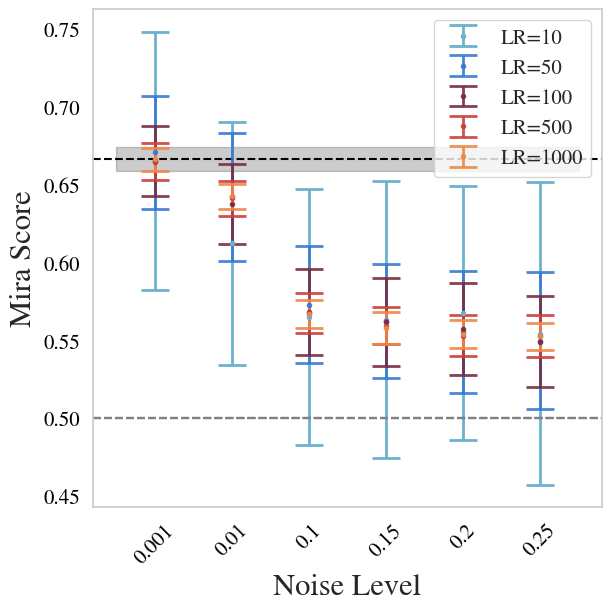

In [17]:
# Sensitivity Mira Result

lr_10_posteriors = (
    [0.6655, 0.6125, 0.5652, 0.5634, 0.5676, 0.5545],
    [0.0828, 0.0779, 0.0823, 0.0889, 0.0814, 0.0971]
)

lr_50_posteriors = (
    [0.6710, 0.6421, 0.5731, 0.5623, 0.5554, 0.5499],
    [0.0362, 0.0410, 0.0376, 0.0366, 0.0393, 0.0442]
)

lr_100_posteriors = (
    [0.6652, 0.6380, 0.5683, 0.5620, 0.5572, 0.5493],
    [0.0226, 0.0257, 0.0277, 0.0282, 0.0296, 0.0292]
)

lr_500_posteriors = (
    [0.6650, 0.6414, 0.5677, 0.5595, 0.5532, 0.5530],
    [0.0120, 0.0114, 0.0129, 0.0118, 0.0130, 0.0136]
)

lr_1000_posteriors = (
    [0.6665, 0.6427, 0.5671, 0.5581, 0.5542, 0.5527],
    [0.0075, 0.0082, 0.0091, 0.0105, 0.0090, 0.0087]
)

# lr_5000_posteriors = (
#     [0.6643, 0.6409, 0.5670, 0.5590, 0.5549, 0.5519],
#     [0.0016, 0.0021, 0.0010, 0.0010, 0.0012, 0.0009]
# )

noise_levels = [0.001, 0.010, 0.100, 0.150, 0.200, 0.250]

posteriors = {
    "LR=10": lr_10_posteriors,
    "LR=50": lr_50_posteriors,
    "LR=100": lr_100_posteriors,
    "LR=500": lr_500_posteriors,
    "LR=1000": lr_1000_posteriors,
    # "LR=5000": lr_5000_posteriors
}

# Make one figure
fig, ax = plt.subplots(figsize=(6, 6))

# Call your function for each metric
for i, (num_fiducials, (scores, errors)) in enumerate(posteriors.items()):
    print(f"Plotting: {num_fiducials} with scores: {scores} and errors: {errors}")
    plot_mira_alone(
        x=np.arange(len(noise_levels)),
        y=scores,
        yerr=errors,
        ax=ax,  # same axis each time
        colors_hex=[data_colors_hex[i % len(data_colors_hex)]],  # pick 1 color
        xtick_labels=[str(nl) for nl in noise_levels],
        xtick_rotation=45,
        xlabel="Noise Level",
        ylabel="Mira Score",
        table_number=f"Table_{i+1}",
        model_name=num_fiducials,
        draw_fill=(i == 0),
        lw=LW,
        L=1000,
        fontsize=FONTSIZE,
        alpha=ALPHA,
        decrease_size=DECREASE_SIZE
    )


fig.set_constrained_layout(True)
fig.savefig("../plots/pdf/LR_Sensitivity_Pokie_Result.pdf")
fig.savefig("../plots/png/LR_Sensitivity_Pokie_Result.png", dpi=300)
plt.show()

## Mira Distance Results

Plotting metric: L2 with scores: [0.6642, 0.6417, 0.5658, 0.5577, 0.5535, 0.5506] and errors: [0.0038, 0.0034, 0.0042, 0.0048, 0.004, 0.0042]
Index 0 | Mira: 0.6642 pm 0.0038
Index 1 | Mira: 0.6417 pm 0.0034
Index 2 | Mira: 0.5658 pm 0.0042
Index 3 | Mira: 0.5577 pm 0.0048
Index 4 | Mira: 0.5535 pm 0.004
Index 5 | Mira: 0.5506 pm 0.0042
Plotting metric: L1 with scores: [0.6633, 0.6417, 0.5768, 0.5689, 0.5626, 0.5589] and errors: [0.0033, 0.0036, 0.0038, 0.0043, 0.0039, 0.0043]
Index 0 | Mira: 0.6633 pm 0.0033
Index 1 | Mira: 0.6417 pm 0.0036
Index 2 | Mira: 0.5768 pm 0.0038
Index 3 | Mira: 0.5689 pm 0.0043
Index 4 | Mira: 0.5626 pm 0.0039
Index 5 | Mira: 0.5589 pm 0.0043
Plotting metric: Chebyshev with scores: [0.6635, 0.6426, 0.5624, 0.5525, 0.5485, 0.5464] and errors: [0.0036, 0.0039, 0.0038, 0.0039, 0.0041, 0.0042]
Index 0 | Mira: 0.6635 pm 0.0036
Index 1 | Mira: 0.6426 pm 0.0039
Index 2 | Mira: 0.5624 pm 0.0038
Index 3 | Mira: 0.5525 pm 0.0039
Index 4 | Mira: 0.5485 pm 0.0041
Index

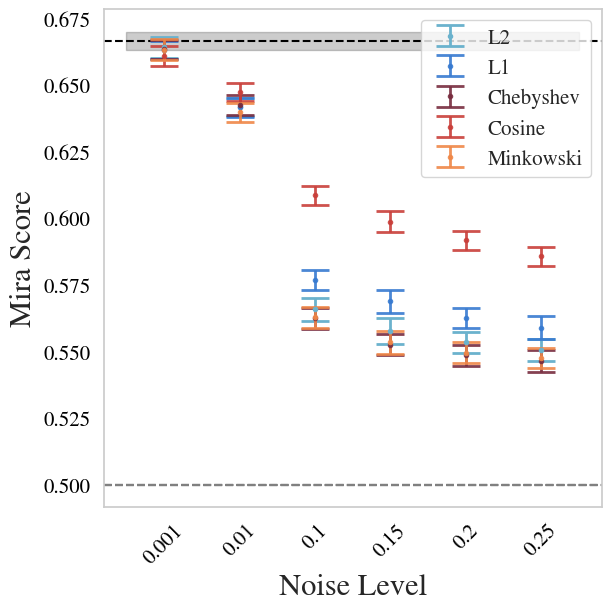

In [18]:
# Distance Mira Result
noise_levels = [0.001, 0.010, 0.100, 0.150, 0.200, 0.250]

metrics = {
    "L2": (
        [0.6642, 0.6417, 0.5658, 0.5577, 0.5535, 0.5506],
        [0.0038, 0.0034, 0.0042, 0.0048, 0.0040, 0.0042]
    ),
    "L1": (
        [0.6633, 0.6417, 0.5768, 0.5689, 0.5626, 0.5589],
        [0.0033, 0.0036, 0.0038, 0.0043, 0.0039, 0.0043]
    ),
    "Chebyshev": (
        [0.6635, 0.6426, 0.5624, 0.5525, 0.5485, 0.5464],
        [0.0036, 0.0039, 0.0038, 0.0039, 0.0041, 0.0042]
    ),
    "Cosine": (
        [0.6609, 0.6476, 0.6086, 0.5987, 0.5918, 0.5858],
        [0.0038, 0.0034, 0.0034, 0.0040, 0.0036, 0.0036]
    ),
    "Minkowski": (
        [0.6634, 0.6399, 0.5628, 0.5534, 0.5495, 0.5476],
        [0.0040, 0.0036, 0.0038, 0.0044, 0.0039, 0.0039]
    )
}

# Make one figure
fig, ax = plt.subplots(figsize=(6, 6))

# Call your function for each metric
for i, (metric_name, (scores, errors)) in enumerate(metrics.items()):
    print(f"Plotting metric: {metric_name} with scores: {scores} and errors: {errors}")
    plot_mira_alone(
        x=np.arange(len(noise_levels)),
        y=scores,
        yerr=errors,
        ax=ax,  # same axis each time
        colors_hex=[data_colors_hex[i % len(data_colors_hex)]],  # pick 1 color
        xtick_labels=[str(nl) for nl in noise_levels],
        xtick_rotation=45,
        draw_fill=(i == 0),
        xlabel="Noise Level",
        ylabel="Mira Score",
        table_number=f"Table_{i+1}",
        model_name=metric_name,  # Pass metric name for legend
        lw=LW,
        L=5000,
        fontsize=FONTSIZE,
        alpha=ALPHA,
        decrease_size=DECREASE_SIZE
    )


fig.set_constrained_layout(True)
fig.savefig("../plots/pdf/Distance_Pokie_Result.pdf")
fig.savefig("../plots/png/Distance_Pokie_Result.png", dpi=300)
plt.show()

## Mira Distribution Results

Plotting distribution: Uniform with scores: [0.6638, 0.6397, 0.5652, 0.5578, 0.5526, 0.5496] and errors: [0.0028, 0.0034, 0.0039, 0.0037, 0.0038, 0.0041]
Index 0 | Mira: 0.6638 pm 0.0028
Index 1 | Mira: 0.6397 pm 0.0034
Index 2 | Mira: 0.5652 pm 0.0039
Index 3 | Mira: 0.5578 pm 0.0037
Index 4 | Mira: 0.5526 pm 0.0038
Index 5 | Mira: 0.5496 pm 0.0041
Plotting distribution: Normal with scores: [0.6633, 0.6395, 0.5525, 0.5405, 0.5348, 0.5301] and errors: [0.0034, 0.0034, 0.004, 0.004, 0.004, 0.0045]
Index 0 | Mira: 0.6633 pm 0.0034
Index 1 | Mira: 0.6395 pm 0.0034
Index 2 | Mira: 0.5525 pm 0.004
Index 3 | Mira: 0.5405 pm 0.004
Index 4 | Mira: 0.5348 pm 0.004
Index 5 | Mira: 0.5301 pm 0.0045
Plotting distribution: Beta(2,5) with scores: [0.6646, 0.6444, 0.5546, 0.5396, 0.5282, 0.5234] and errors: [0.0034, 0.0037, 0.0041, 0.0038, 0.0039, 0.0044]
Index 0 | Mira: 0.6646 pm 0.0034
Index 1 | Mira: 0.6444 pm 0.0037
Index 2 | Mira: 0.5546 pm 0.0041
Index 3 | Mira: 0.5396 pm 0.0038
Index 4 | Mira:

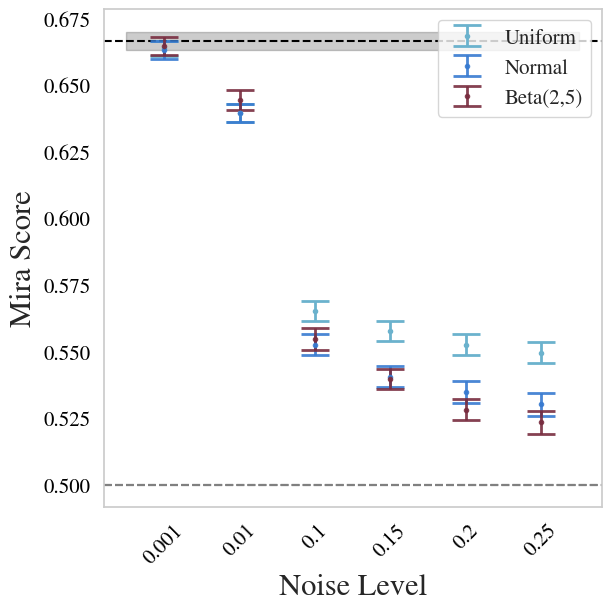

In [19]:
# Distribution Mira Result
# Table Distribution_Choice
noise_levels = [0.001, 0.010, 0.100, 0.150, 0.200, 0.250]

# Scores and 68% CI errors for each center distribution
distributions = {
    "Uniform": (
        [0.6638, 0.6397, 0.5652, 0.5578, 0.5526, 0.5496],
        [0.0028, 0.0034, 0.0039, 0.0037, 0.0038, 0.0041]
    ),
    "Normal": (
        [0.6633, 0.6395, 0.5525, 0.5405, 0.5348, 0.5301],
        [0.0034, 0.0034, 0.0040, 0.0040, 0.0040, 0.0045]
    ),
    "Beta(2,5)": (
        [0.6646, 0.6444, 0.5546, 0.5396, 0.5282, 0.5234],
        [0.0034, 0.0037, 0.0041, 0.0038, 0.0039, 0.0044]
    )
}

# Make one figure
fig, ax = plt.subplots(figsize=(6, 6))

# Call your function for each distribution
for i, (distribution_name, (scores, errors)) in enumerate(distributions.items()):
    print(f"Plotting distribution: {distribution_name} with scores: {scores} and errors: {errors}")
    plot_mira_alone(
        x=np.arange(len(noise_levels)),
        y=scores,
        yerr=errors,
        ax=ax,  # same axis each time
        colors_hex=[data_colors_hex[i % len(data_colors_hex)]],  # pick 1 color
        xtick_labels=[str(nl) for nl in noise_levels],
        xtick_rotation=45,
        xlabel="Noise Level",
        ylabel="Mira Score",
        table_number=f"Table_{i+1}",
        draw_fill=(i == 0),
        model_name=distribution_name,  # Pass distribution name for legend
        lw=LW,
        L=5000,
        fontsize=FONTSIZE,
        alpha=ALPHA,
        decrease_size=DECREASE_SIZE
    )


fig.set_constrained_layout(True)
fig.savefig("../plots/pdf/Center_Distribution_Pokie_Result.pdf")
fig.savefig("../plots/png/Center_Distribution_Pokie_Result.png", dpi=300)
plt.show()

## Mira Ellipse Results

Plotting shape size: (1.0, 2.0) with scores: [0.6669, 0.652, 0.5801, 0.5652, 0.5566, 0.5492] and errors: [0.0038, 0.0051, 0.0055, 0.0051, 0.0045, 0.0057]
Index 0 | Mira: 0.6669 pm 0.0038
Index 1 | Mira: 0.652 pm 0.0051
Index 2 | Mira: 0.5801 pm 0.0055
Index 3 | Mira: 0.5652 pm 0.0051
Index 4 | Mira: 0.5566 pm 0.0045
Index 5 | Mira: 0.5492 pm 0.0057
Plotting shape size: (0.5, 1.5) with scores: [0.6656, 0.655, 0.5834, 0.565, 0.5527, 0.5442] and errors: [0.0044, 0.004, 0.0044, 0.0045, 0.0049, 0.0051]
Index 0 | Mira: 0.6656 pm 0.0044
Index 1 | Mira: 0.655 pm 0.004
Index 2 | Mira: 0.5834 pm 0.0044
Index 3 | Mira: 0.565 pm 0.0045
Index 4 | Mira: 0.5527 pm 0.0049
Index 5 | Mira: 0.5442 pm 0.0051
Plotting shape size: (1.5, 1.0) with scores: [0.6629, 0.6376, 0.5521, 0.5416, 0.5374, 0.5351] and errors: [0.0048, 0.0051, 0.005, 0.0058, 0.0056, 0.0044]
Index 0 | Mira: 0.6629 pm 0.0048
Index 1 | Mira: 0.6376 pm 0.0051
Index 2 | Mira: 0.5521 pm 0.005
Index 3 | Mira: 0.5416 pm 0.0058
Index 4 | Mira: 0

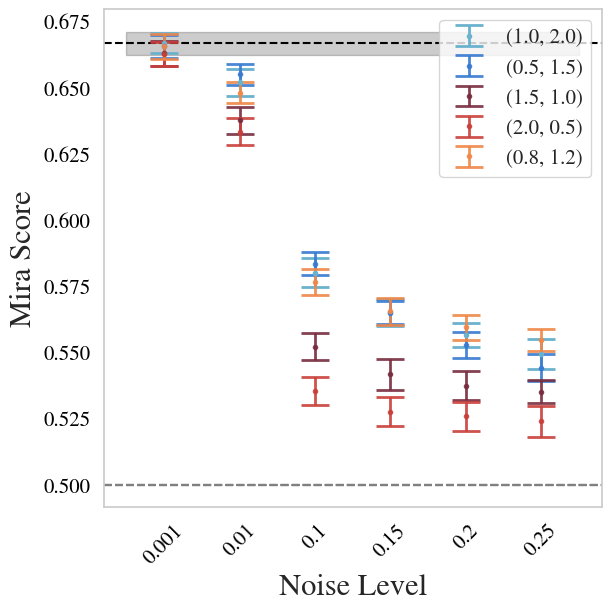

In [20]:
# Ellipse Mira Result
# Table Region_Choice (Ellipse Stretch Configurations)
noise_levels = [0.001, 0.010, 0.100, 0.150, 0.200, 0.250]

# Scores and errors by ellipse stretch configuration
ellipse_configs = {
    "(1.0, 2.0)": (
        [0.6669, 0.6520, 0.5801, 0.5652, 0.5566, 0.5492],
        [0.0038, 0.0051, 0.0055, 0.0051, 0.0045, 0.0057]
    ),
    "(0.5, 1.5)": (
        [0.6656, 0.6550, 0.5834, 0.5650, 0.5527, 0.5442],
        [0.0044, 0.0040, 0.0044, 0.0045, 0.0049, 0.0051]
    ),
    "(1.5, 1.0)": (
        [0.6629, 0.6376, 0.5521, 0.5416, 0.5374, 0.5351],
        [0.0048, 0.0051, 0.0050, 0.0058, 0.0056, 0.0044]
    ),
    "(2.0, 0.5)": (
        [0.6627, 0.6332, 0.5354, 0.5276, 0.5258, 0.5239],
        [0.0044, 0.0051, 0.0053, 0.0055, 0.0054, 0.0058]
    ),
    "(0.8, 1.2)": (
        [0.6655, 0.6481, 0.5766, 0.5654, 0.5595, 0.5545],
        [0.0046, 0.0041, 0.0048, 0.0051, 0.0047, 0.0042]
    )
}

# Make one figure
fig, ax = plt.subplots(figsize=(6, 6))

# Call your function for each distribution
for i, (shape_size, (scores, errors)) in enumerate(ellipse_configs.items()):
    print(f"Plotting shape size: {shape_size} with scores: {scores} and errors: {errors}")
    plot_mira_alone(
        x=np.arange(len(noise_levels)),
        y=scores,
        yerr=errors,
        ax=ax,  # same axis each time
        colors_hex=[data_colors_hex[i % len(data_colors_hex)]],  # pick 1 color
        xtick_labels=[str(nl) for nl in noise_levels],
        xtick_rotation=45,
        xlabel="Noise Level",
        ylabel="Mira Score",
        table_number=f"Table_{i+1}",
        model_name=shape_size,  # Pass shape size for legend
        LR=False,
        draw_fill=(i == 0),
        lw=LW,
        L=3000,
        fontsize=FONTSIZE,
        alpha=ALPHA,
        decrease_size=DECREASE_SIZE
    )


fig.set_constrained_layout(True)
fig.savefig("../plots/pdf/Shape_Size_Pokie_Result.pdf")
fig.savefig("../plots/png/Shape_Size_Pokie_Result.png", dpi=300)
plt.show()

## Sensitivity Aggregated Analysis

In [21]:
from torch import std


def plot_all_mira_experiments(
    dimensions, 
    hyperspheres, 
    posterior_samples,
    L,
    shifts=None,
    colors_hex=None,
    lw=5,
    legend_fontsize=8,
    well_calibrated_color=None,
    poorly_calibrated_color=None,
    underconfidence_color=None,
    save_path=None,
    fontsize=20,
    markersize=2,
    markeredgewidth=2,
    elinewidth=2,
    alpha=0.5,
    capsize=10,
    decrease_size=2,
):
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib as mpl
    from collections import OrderedDict

    x_label_font_size = fontsize
    y_label_font_size = fontsize
    tick_label_size = fontsize - decrease_size
    legend_font_size = fontsize - decrease_size

    if shifts is None:
        shifts = [-6, -3, 0, 3, 6]
    if colors_hex is None:
        # Fallback color set
        colors_hex = get_diverse_icefire_colors(10)[1]

    # fig, axs = plt.subplots(2, 2, figsize=(7, 7))
    # axs = axs.flatten()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Helper to plot each group
    def plot_group(ax, data, title, xlabel):
        ax.grid(False)
        for i, (label, values) in enumerate(data.items()):
            ax.errorbar(
                shifts,
                values["scores"],
                yerr=values["errors"],
                fmt='o',
                capsize=capsize,
                color=colors_hex[i % len(colors_hex)],
                markersize=markersize,
                alpha=1.0,
                markeredgewidth=markeredgewidth,
                elinewidth=elinewidth,
                label=label,
            )
        ax.axhline(1/2, color='gray', linestyle='--', alpha = 1.0, lw=1.5, label='Poorly Calibrated')

        # ax.axhline((1/2 + 1/np.sqrt(12)), color='gray', linestyle='--', alpha = 1.0, lw=1.5, label='Underconfident')


        # Titles, labels, formatting
        ax.set_title(title, fontsize=25, fontweight='bold')
        ax.set_xlabel(xlabel, fontsize=x_label_font_size)
        # If ax is the leftmost, set y label
        if ax == axs[0]:
            ax.set_ylabel("Mira Score", fontsize=y_label_font_size)
        ax.tick_params(axis='x', labelsize=tick_label_size)
        ax.tick_params(axis='y', labelsize=tick_label_size)

        # Set x ticks to shifts
        ax.set_xticks(shifts)
        formatter = mpl.ticker.FormatStrFormatter('%.2f')
        ax.yaxis.set_major_formatter(formatter)
        # ax.set_ylim(0.48, 0.68)

        # Deduplicated legend
        handles, labels = ax.get_legend_handles_labels()
        by_label = OrderedDict(zip(labels, handles))
        if 'Well Calibrated' in by_label:
            by_label.pop('Well Calibrated')
        if 'Poorly Calibrated' in by_label:
            by_label.pop('Poorly Calibrated')
        if 'Underconfident' in by_label:
            by_label.pop('Underconfident')
        ax.legend(
            by_label.values(),
            by_label.keys(),
            fontsize=legend_fontsize,
            loc="upper right"
        )

        # Calibration lines
        variance = (1/18)/L
        std = np.sqrt(variance)
        ax.axhline(2/3, color='black', linestyle='--', alpha = 1.0, lw=1.5, label='Well Calibrated')
        support = np.linspace(-7, 7, 100)
        ax.fill_between(support, 2/3 - std, 2/3 + std, alpha=0.2, color='black')
        ax.set_xlim(-7, 7)

    # Apply to each subplot
    plot_group(axs[0], dimensions, "Varying Dimensions", "Shift Value")
    plot_group(axs[1], hyperspheres, "Varying Number of Regions", "Shift Value")
    plot_group(axs[2], posterior_samples, "Varying Posterior Samples", "Shift Value")
    # Decrease plot title size
    for ax in axs:
        ax.title.set_size(17)
    # axs[3].axis('off')

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

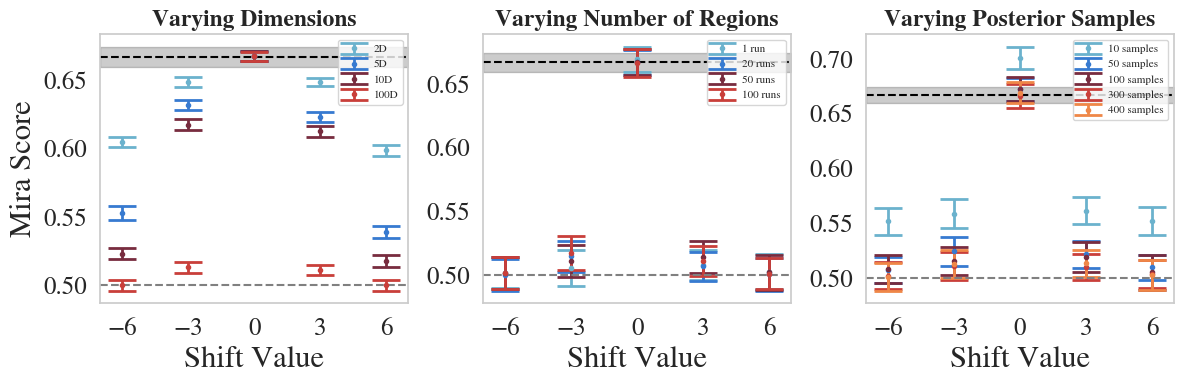

In [22]:
# Sensitivity Test (2 x 2 plot with lower right turned off) Top Left: Dimensions Test, Top Right: L, Bottom Left: Num of Samples

dimensions = {
    "2D": {
        "scores": [0.6045, 0.6483, 0.6669, 0.6481, 0.5984],
        "errors": [0.0038, 0.0033, 0.0031, 0.0030, 0.0040]
    },
    "5D": {
        "scores": [0.5526, 0.6315, 0.6671, 0.6228, 0.5389],
        "errors": [0.0050, 0.0037, 0.0035, 0.0039, 0.0045]
    },
    "10D": {
        "scores": [0.5233, 0.6171, 0.6670, 0.6124, 0.5176],
        "errors": [0.0041, 0.0040, 0.0037, 0.0039, 0.0044]
    },
    "100D": {
        "scores": [0.5000, 0.5132, 0.6669, 0.5113, 0.5002],
        "errors": [0.0042, 0.0042, 0.0034, 0.0038, 0.0040]
    }
}

hyperspheres = {
    "1 run": {
        "scores": [0.50174594, 0.5056617, 0.6693001, 0.50787807, 0.50258905],
        "errors": [0.01206928, 0.01407796, 0.00984546, 0.01173354, 0.01393633]
    },
    "20 runs": {
        "scores": [0.49978226, 0.51480174, 0.66691643, 0.5067856, 0.5003773],
        "errors": [0.01241044, 0.01214088, 0.00971929, 0.01128353, 0.01315701]
    },
    "50 runs": {
        "scores": [0.5013516, 0.5108235, 0.66729254, 0.5139341, 0.5020315],
        "errors": [0.01271933, 0.01252874, 0.01006315, 0.01246938, 0.01378876]
    },
    "100 runs": {
        "scores": [0.5016635, 0.51724625, 0.666212, 0.51095235, 0.50109875],
        "errors": [0.01265017, 0.01357112, 0.011236, 0.01181128, 0.01200862]
    }
}

posterior_samples = {
    "10 samples": {
        "scores": [0.551524, 0.558326, 0.700476, 0.561078, 0.551656],
        "errors": [0.01227844, 0.01295106, 0.01041854, 0.01242701, 0.01262283]
    },
    "50 samples": {
        "scores": [0.5068244, 0.52390444, 0.6718412, 0.521318, 0.50925756],
        "errors": [0.01214749, 0.01329519, 0.01028553, 0.01222892, 0.01169688]
    },
    "100 samples": {
        "scores": [0.5075212, 0.5151786, 0.6719145, 0.51890856, 0.504944],
        "errors": [0.01285653, 0.01281209, 0.01091054, 0.01374135, 0.0159563]
    },
    # "200 samples": {
    #     "scores": [0.5036858, 0.51340437, 0.6679275, 0.5200728, 0.5014128],
    #     "errors": [0.01274271, 0.00955724, 0.01060478, 0.013953, 0.01276546]
    # },
    "300 samples": {
        "scores": [0.5016408, 0.5107455, 0.6657693, 0.50997925, 0.5033823],
        "errors": [0.01237438, 0.01296766, 0.01058149, 0.01192634, 0.0130619]
    },
    "400 samples": {
        "scores": [0.50039786, 0.5123267, 0.6688564, 0.5128226, 0.5022506],
        "errors": [0.01289913, 0.01267484, 0.00940202, 0.01235659, 0.01377634]
    },
    # "500 samples": {
    #     "scores": [0.5017785, 0.5091051, 0.66844094, 0.5131277, 0.49969608],
    #     "errors": [0.01258485, 0.01200053, 0.01023337, 0.01384445, 0.01199949]
    # }
}

'''
Colors
Legend
Size of Markers

'''
FONTSIZE = 22
LW = 1.5
ALPHA = 0.9
MARKERDGEWIDTH = 1.5
MARKERSIZE = 5
ELINEWIDTH = 2
CAPSIZE = 10
DECREASE_SIZE = 4

model_shifts = [-6, -3, 0, 3, 6]

plot_all_mira_experiments(
    dimensions=dimensions,
    hyperspheres=hyperspheres,
    posterior_samples=posterior_samples,
    colors_hex=data_colors_hex, 
    lw=LW,
    L=1000,
    fontsize=FONTSIZE,
    alpha=ALPHA,
    decrease_size=DECREASE_SIZE,
    save_path="../plots/pdf/Sensitivity_All_Experiments.pdf"
)


## Conditional Generative Model Plots

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mira_curve(
    ax,
    epochs,
    scores,
    *,
    label,
    color,
    L=1000,
    lw=1.5,
    alpha=0.9,
    markersize=6,
    markeredgewidth=1.5,
    eline_alpha=0.15,
    fontsize=15,
    show_reference=True,
):
    """
    Plot a single MIRA curve with error band and calibration references.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axis to plot on
    epochs : 1D np.ndarray
        Epoch numbers
    scores : 1D np.ndarray
        Average MIRA scores
    label : str
        Label for legend
    color : str
        Line/marker color
    L : int
        Number of fiducials (controls error size)
    """

    # --- Error model (your theoretical bound)
    std = np.sqrt((1 / 18) / L)

    # --- Main curve
    ax.plot(
        epochs,
        scores,
        marker='o',
        lw=lw,
        color=color,
        alpha=alpha,
        markersize=markersize,
        markeredgewidth=markeredgewidth,
        label=label,
    )

    # --- Error band
    ax.fill_between(
        epochs,
        scores - std,
        scores + std,
        color=color,
        alpha=eline_alpha,
        linewidth=0,
    )

    # --- Reference calibration lines
    if show_reference:
        ax.axhline(0.5, color='gray', linestyle='--', lw=lw, alpha = 1.0)
        ax.axhline(2/3, color='black', linestyle='--', lw=lw, alpha = 1.0)
        # ax.axhline(0.5 + 1/np.sqrt(12), color='gray', linestyle='--', lw=lw)
        variance = (1/18)/1000
        std = np.sqrt(variance)
        support = epochs
        ax.fill_between(support, 2/3 - std, 2/3 + std, alpha=0.2, color='black')

    # --- Axis formatting
    ax.set_xlim(epochs[0] - 0.5, epochs[-1] + 0.5)
    ax.set_ylabel("MIRA Score", fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=fontsize - 2)

## Training Curves

Functions for plotting training curves.

/var/folders/jv/k_v96nss5g52chcq2phrbl240000gn/T/ipykernel_77990/2669774474.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/jv/k_v96nss5g52chcq2phrbl240000gn/T/ipykernel_77990/2669774474.py:203: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


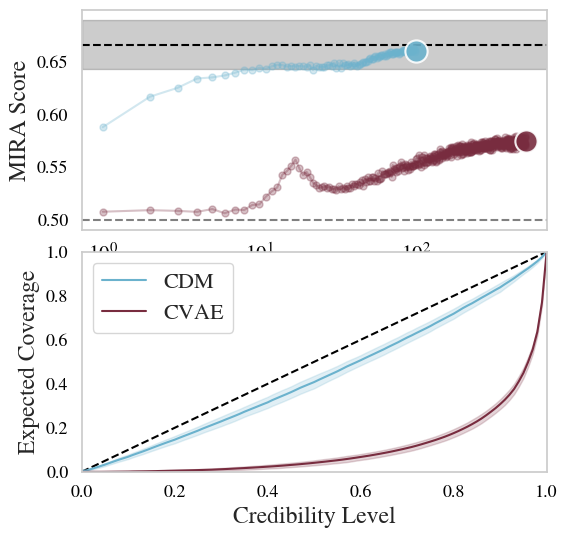

In [ ]:
import matplotlib as mpl
def plot_mira_training_curves(
    ax,
    cache,
    models,
    colors_hex,
    L=100,
    ylabel='MIRA Score',
    xlabel='Epoch',
    title=None,
    lw=1.5,
    fontsize=20,
    markersize_trail=3,
    markersize_final=10,
    markeredgewidth=1.5,
    alpha_trail=0.3,
    alpha_final=1.0,
    decrease_size=2,
    well_calibrated_line=True,
    poorly_calibrated_line=True,
    conditional_distribution=None,
):
    """
    Plot MIRA score as a function of training epoch with faded training history
    and bold final points to emphasize final results.
    
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes to plot on
    cache : dict-like
        Data cache containing '{model}_epochs' and '{model}_scores' arrays
    models : list of str
        Model names to plot (e.g., ["CDM V1", "CVAE V1"])
    colors_hex : list of str
        Colors for each model
    L : int
        Number of samples (for computing well-calibrated uncertainty band)
    ylabel : str
        Y-axis label
    xlabel : str
        X-axis label
    title : str, optional
        Plot title
    lw : float
        Line width for training curves
    fontsize : int
        Base font size
    markersize_trail : float
        Marker size for faded training history
    markersize_final : float
        Marker size for final (bold) points
    markeredgewidth : float
        Edge width for final markers
    alpha_trail : float
        Opacity for training history (faded)
    alpha_final : float
        Opacity for final points (bold)
    decrease_size : int
        Amount to decrease font size for ticks/legend
    well_calibrated_line : bool
        Whether to show the well-calibrated reference line at 2/3
    poorly_calibrated_line : bool
        Whether to show the poorly-calibrated reference line at 1/2
    """
    
    tick_label_size = fontsize - decrease_size
    legend_font_size = fontsize - decrease_size
    
    ax.grid(False)
    
    # Track x-range for fill_between
    all_epochs = []
    x_min = 1
    x_max = 500
    # Reference lines
    if poorly_calibrated_line:
        ax.axhline(1/2, color='gray', linestyle='--', alpha=1.0, lw=lw)
    
    if well_calibrated_line:
        ax.axhline(2/3, color='black', linestyle='--', alpha=1.0, lw=lw)
        # Uncertainty band
        variance = (1/18) / L
        std = np.sqrt(variance)
        
        # axhspan automatically spans the full x-axis, regardless of scale
        ax.axhspan(2/3 - std, 2/3 + std, alpha=0.2, color='black')
    
    for model, color in zip(models, colors_hex):
        epochs = cache[f"{model}_epochs"]
        scores = cache[f"{model}_scores"]
        all_epochs.extend(epochs)
        
        # Plot the training trajectory (faded)
        ax.plot(
            epochs[:-1], scores[:-1],
            color=color,
            alpha=alpha_trail,
            marker='o',
            markersize=markersize_trail,
            linewidth=lw
        )
        
        # Connect last faded point to final point (faded line)
        ax.plot(
            epochs[-2:], scores[-2:],
            color=color,
            alpha=alpha_trail,
            linewidth=lw
        )
        
        # Plot the final point (bold) with label
        ax.plot(
            epochs[-1], scores[-1],
            color=color,
            alpha=alpha_final,
            marker='o',
            markersize=markersize_final,
            markeredgecolor='white',
            markeredgewidth=markeredgewidth,
            label=f"{model[:-3]}", # the model name minus the last 3 characters
            linestyle='None'
        )

    # Formatting
    if title:
        ax.set_title(title, fontsize=fontsize, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=15, colors='black')
    ax.tick_params(axis='y', labelsize=tick_label_size, colors='black')
    
    # Format y-axis to two decimal places
    formatter = mpl.ticker.FormatStrFormatter('%.2f')
    ax.yaxis.set_major_formatter(formatter)
    
    # ax.legend(fontsize=legend_font_size, loc='upper left')
    # Log the x axis
    ax.set_xscale('log')
    return ax

models = ["Conditional\nDiffusion Model", "Conditional\nVAE"]

scores = [0.6599, 0.5748]
errors = [0.0248, 0.0276]

L =100

cache = np.load(f"{PATH}/Conditional_Gen_Model_Data/mira_cache.npz")

# One model from each family
models_to_plot = ["CDM V1", "CVAE V1"]

L = 100
fig, (ax_top, ax_bottom) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(6, 6),
    gridspec_kw={'hspace': 0.1}
)

FONTSIZE = 17
LW = 1.5
ALPHA = 0.9
MARKERDGEWIDTH = 1.5
MARKERSIZE = 10
ELINEWIDTH = 2
CAPSIZE = 10
DECREASE_SIZE = 4

# Top panel: MIRA training curves
plot_mira_training_curves(
    ax=ax_top,
    cache=cache,
    models=models_to_plot,
    colors_hex=[data_colors_hex[0], data_colors_hex[2]],  # CDM color, CVAE color
    L=L,
    ylabel='MIRA Score',
    xlabel='Epoch',
    lw=LW,
    fontsize=FONTSIZE,
    markersize_trail=5,
    markersize_final=MARKERSIZE+6,
    markeredgewidth=MARKERDGEWIDTH,
    alpha_trail=0.3,
    alpha_final=ALPHA,
    decrease_size=DECREASE_SIZE,
)

plot_validation_result(
    ax=ax_bottom, 
    experiment_type='conditional_distribution', 
    data_colors_hex=[data_colors_hex[0], data_colors_hex[2]],
    lw=LW,
    fontsize=FONTSIZE,
    alpha=ALPHA,
    decrease_size=DECREASE_SIZE 
    )



fig.set_constrained_layout(True)
fig.savefig('../plots/pdf/MIRA_CModel_PLot.pdf')
fig.savefig('../plots/png/MIRA_CModel_PLot.png', dpi=300)